# Evaluate the Effect of Varying Prompts

In [1]:
import torch
import os
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as pltcolors

import json
from pathlib import Path
import matplotlib as mpl
import pandas as pd
import numpy as np

import folktexts
from folktexts.llm_utils import get_model_size_B
#load the dataset
from folktexts.acs.acs_tasks import ACSTaskMetadata
from folktexts.acs.acs_dataset import ACSDataset

#baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from folktexts.evaluation import evaluate_predictions
from folktexts._io import load_json, save_json

plot_config_file = "./results/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

data_dir = Path(".--data")

In [2]:
LLM_MODELS = [ # LLMs to evaluate
    # Google Gemma2 models
    "google/gemma-2b",
    "google/gemma-1.1-2b-it",
    "google/gemma-7b",
    "google/gemma-1.1-7b-it",
    "google/gemma-2-9b",
    "google/gemma-2-9b-it",
    "google/gemma-2-27b",
    "google/gemma-2-27b-it",
    # Meta Llama3 models
    "meta-llama/Meta-Llama-3-8B",
    "meta-llama/Meta-Llama-3-8B-Instruct",
    "meta-llama/Meta-Llama-3-70B",
    "meta-llama/Meta-Llama-3-70B-Instruct",
    # Mistral AI models
    "mistralai/Mistral-7B-v0.1",
    "mistralai/Mistral-7B-Instruct-v0.2",
    "mistralai/Mixtral-8x7B-v0.1",
    "mistralai/Mixtral-8x7B-Instruct-v0.1",
    "mistralai/Mixtral-8x22B-v0.1",
    "mistralai/Mixtral-8x22B-Instruct-v0.1",
    # Yi models
    "01-ai/Yi-34B",
    "01-ai/Yi-34B-Chat",
    # Qwen2 models
    # "Qwen/Qwen2-1.5B",
    # "Qwen/Qwen2-1.5B-Instruct",
    # "Qwen/Qwen2-7B",
    # "Qwen/Qwen2-7B-Instruct",
    # "Qwen/Qwen2-72B",
    # "Qwen/Qwen2-72B-Instruct",
]

## ACS Tasks

In [129]:
# All ACS prediction tasks
ACS_TASKS = (
    "ACSIncome",
    "ACSEmployment",
    "ACSMobility",
    #"ACSTravelTime",
    "ACSPublicCoverage",
)

In [130]:
task_name = ACS_TASKS[0]
acs_task = ACSTaskMetadata.get_task(task_name)
acs_dataset_configs = folktexts.benchmark.Benchmark.ACS_DATASET_CONFIGS.copy()

## Load LLM predictions

In [5]:
# What changes were made to the prompts
prompt_styles = ['bullet', 'text']
prompt_connectors = ['is', ':', '=']
prompt_connectors_extended = ['is', ':', '=', 'text']
shots = [0,3,5]

In [111]:
RESULTS_ROOT_DIR = Path("./results/vary-prompts/")
RESULTS_ROOT_DIR_FIG = str(RESULTS_ROOT_DIR) + '/figures/'

In [7]:
## Utility functions for data loading


def load_json(path: str | Path) -> object:
    """Loads a JSON file from disk and returns the deserialized object."""
    with open(path, "r") as f_in:
        return json.load(f_in)


def find_files(root_folder, pattern, dir_pattern=""):
    # Compile the regular expression pattern
    regex = re.compile(pattern)

    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(root_folder):
        if dir_pattern in dirpath:
            for filename in filenames:
                if regex.match(filename):
                    # If the filename matches the pattern, add it to the list
                    yield os.path.join(dirpath, filename)


def parse_model_name(name: str) -> str:
    name = name[name.find("--") + 2 :]
    return name


def get_base_name(name):
    name = name.replace("-Instruct", "")
    name = name.replace("-Chat", "")
    name = name.replace("-it", "")
    name = name.replace("-1.1", "")
    name = name.replace("-v0.2", "-v0.1")
    return name


model_col = "config_model_name"
# model_col = "model_name"
feature_subset_col = "config_feature_subset"
population_subset_col = "config_population_filter"
predictions_path_col = "predictions_path"

uses_all_features_col = "uses_all_features"
uses_all_samples_col = "uses_all_samples"


def parse_results_dict(dct) -> dict:
    """Parses results dict; brings all information to the top-level."""
    dct = dct.copy()
    dct.pop("plots", None)
    config = dct.pop("config", {})
    for key, val in config.items():
        dct[f"config_{key}"] = val

    # Parse model name
    dct[model_col] = parse_model_name(dct[model_col])
    dct[uses_all_features_col] = dct[feature_subset_col] is None
    if dct[feature_subset_col] is None:
        dct[feature_subset_col] = "full"

    dct[uses_all_samples_col] = dct[population_subset_col] is None

    dct["base_name"] = get_base_name(dct[model_col])
    dct["is_inst"] = dct["base_name"] != dct[model_col]

    assert not any(isinstance(val, dict) for val in dct.values()), dct
    return dct

In [8]:
load_df = True

if load_df:
    df = pd.read_csv('./results/vary-prompts/overview.csv', index_col=0)
else:
    results_all_tasks = []  # [task][identifier][bench]
    for task_name in ACS_TASKS:
        # Results file name pattern
        pattern_json = r"^results.bench-(?P<hash>\d+)[.]json$" 
        # Find results files
        results = {}
        for file_path in find_files(RESULTS_ROOT_DIR, pattern_json, dir_pattern=task_name):
            identifier = (
                Path(file_path)
                .parent.parent.name.replace(f".dataset-{task_name}", "")
                .replace("model-", "")
            )
            bench_id = Path(file_path).parent.name.split("_bench-")[1]
            print(identifier, bench_id)

            parsed_results = parse_results_dict(load_json(file_path))
            res = [task_name, 
                identifier.split('_task-')[0], 
                bench_id, 
                0 if parsed_results['config_few_shot'] is None else parsed_results['config_few_shot'], 
                parsed_results['config_prompt_style'],  
                parsed_results['config_prompt_connector'], 
                file_path, 
                parsed_results["predictions_path"].split('folktexts/')[1]]
            results_all_tasks.append(res)

    df = pd.DataFrame(results_all_tasks, columns = ['task', 'model', 'bench_id', 'shots', 'prompt_style', 'prompt_connector', 'eval_results_path', 'predictions_path']) 
    df.to_csv('./results/vary-prompts/overview.csv')

In [9]:
print(df.shape)
df.head()

(811, 8)


,task,model,bench_id,shots,prompt_style,prompt_connector,eval_results_path,predictions_path
0,ACSIncome,google--gemma-2b,1872485127,0,bullet,is,results/vary-prompts/model-google--gemma-2b_ta...,results/vary-prompts/model-google--gemma-2b_ta...
1,ACSIncome,google--gemma-2b,1000237644,0,bullet,:,results/vary-prompts/model-google--gemma-2b_ta...,results/vary-prompts/model-google--gemma-2b_ta...
2,ACSIncome,google--gemma-2b,838083206,0,bullet,=,results/vary-prompts/model-google--gemma-2b_ta...,results/vary-prompts/model-google--gemma-2b_ta...
3,ACSIncome,google--gemma-2b,3932676696,0,text,is,results/vary-prompts/model-google--gemma-2b_ta...,results/vary-prompts/model-google--gemma-2b_ta...
4,ACSIncome,google--gemma-2b,737954418,3,text,is,results/vary-prompts/model-google--gemma-2b_ta...,results/vary-prompts/model-google--gemma-2b_ta...


## Baselines

In [10]:
baselines = {
    "Constant": DummyClassifier(strategy='prior'),
    "LR": LogisticRegression(),
    "GBM": HistGradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
}
BASELINE_RESULTS_PATH =  Path('./results/eval-fairness/baseline-results')

In [11]:
def load_baselines(tasks: list, rerun: bool=False):
    baseline_results_all_tasks = {}
    baseline_risk_scores_all_tasks = {}
    for task_name in tasks:
        results = {}
        risk_scores = []
        for clf_name, clf in baselines.items():
            clf_path = BASELINE_RESULTS_PATH / f"{clf_name}_task-{task_name}"
            if (clf_path).exists() and not rerun:
                print("Load predictions from file.")
                scores = pd.read_csv(clf_path / f'{task_name}.test_predictions.csv')
                prediction_eval = load_json(path=clf_path / f'{task_name}-results.bench.json')
            else: 
                print(f'Skipping {clf_name}')
            results[clf_name] = prediction_eval
            risk_scores.append(scores)

        baseline_results_all_tasks[task_name] = results
        baseline_risk_scores_all_tasks[task_name] = pd.concat(risk_scores, axis=1)

    return baseline_risk_scores_all_tasks, baseline_results_all_tasks

In [12]:
baseline_scores, baseline_evals = load_baselines(tasks=ACS_TASKS)

Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.


## Utils

In [13]:
colors = cm.rainbow(np.linspace(0, 1, len(baselines.keys())+1))[1:]
baseline_colors = {list(baselines.keys())[i]: colors[i] for i in range(len(baselines.keys()))}


model_colors = {
    "gemma": "tab:blue",
    "Meta": "tab:olive",
    "Mistral": "tab:orange",
    "Yi": "tab:green",
    "Mixtral": "tab:red",
}

In [14]:
def get_risk_scores_df(df=df):
    risk_scores = []
    for csv_path in df['predictions_path'].to_list():
            risk_scores.append(
                get_risk_scores(csv_path)
            )
    return pd.concat(risk_scores, axis=1)

def get_risk_scores(csv_path):
    risk_score = pd.read_csv(csv_path, index_col=0).drop("label", axis=1).rename(columns={"risk_score": csv_path.split('model-')[1].split("_task-")[0]})
    return risk_score


def binarize_risk_scores(risk_scores: pd.DataFrame):
      # thresholds not easily available here! (currently 0.5 anyway)
      return risk_scores.map(lambda x: int(x>0.5))


model_to_key = lambda m: m.replace("/", "--")
key_to_model = lambda m: m.replace("--", "/")

def prettify_model_name(name: str) -> str:
    """Get prettified version of the given model name."""
    dct = {
        "meta-llama/Meta-Llama-3-70B": "Llama 3 70B",
        "meta-llama/Meta-Llama-3-70B-Instruct": "Llama 3 70B (it)",
        "meta-llama/Meta-Llama-3-8B": "Llama 3 8B",
        "meta-llama/Meta-Llama-3-8B-Instruct": "Llama 3 8B (it)",
        "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B (it)",
        "mistralai/Mistral-7B-v0.1": "Mistral 7B",
        "mistralai/Mixtral-8x22B-Instruct-v0.1": "Mixtral 8x22B (it)",
        "mistralai/Mixtral-8x22B-v0.1": "Mixtral 8x22B",
        "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B (it)",
        "mistralai/Mixtral-8x7B-v0.1": "Mixtral 8x7B",
        "01-ai/Yi-34B": "Yi 34B",
        "01-ai/Yi-34B-Chat": "Yi 34B (chat)",
        "google/gemma-1.1-2b-it": "Gemma 2B (it)",
        "google/gemma-1.1-7b-it": "Gemma 7B (it)",
        "google/gemma-2b": "Gemma 2B",
        "google/gemma-7b": "Gemma 7B",
        "google/gemma-2-9b": "Gemma 2 9B",
        "google/gemma-2-9b-it": "Gemma 2 9B (it)",
        "google/gemma-2-27b": "Gemma 2 27B",
        "google/gemma-2-27b-it": "Gemma 2 27B (it)",
    }

    if name in dct:
        return dct[name]
    else:
        print(f"Couldn't find prettified name for {name}.")
        return name
    
def is_instruction_tuned(model_name: str) -> bool:
    """ Indicator if a model is instruction tuned (solely inferred from the model name).

    Args:
        model_name (str): name of the model

    Returns:
        bool: model is instruction-finetuned
    """
    indicators = ["Instruct", "it", "Chat"]
    return any(ind in model_name for ind in indicators)

In [15]:
def get_predictions_per_prompt(df):
    risk_scores_prompt = {':': None, 'is': None, '=' : None, 'text': None}
    for connector in prompt_connectors_extended:
        print(connector)
        if connector in prompt_connectors:
            subset = df[(df['prompt_style']=='bullet') & (df['prompt_connector']==connector)]
        elif connector=='text':
            subset = df[(df['prompt_style']==connector)]
        else:
            continue
        if subset.shape[0] > 0:
            risk_scores_prompt[connector] = get_risk_scores_df(subset)
    predictions_prompt = {key : binarize_risk_scores(scores) for (key, scores) in risk_scores_prompt.items()}
    
    return risk_scores_prompt, predictions_prompt

# get accuracies of models
def get_metric_per_prompt(df, metric):
    metric_per_prompt = {':': None, 'is': None, '=' : None, 'text': None}
    for connector in prompt_connectors_extended:
        if connector in prompt_connectors:
            subset = df[(df['prompt_style']=='bullet') & (df['prompt_connector']==connector)]
        elif connector=='text':
            subset = df[(df['prompt_style']==connector)]
        else:
            continue
        eval_dict = {}
        for csv_path in subset['eval_results_path'].to_list():
            evals = load_json(csv_path)
            eval_dict[evals['model_name']] = evals[metric]
        metric_per_prompt[connector] = eval_dict
    return metric_per_prompt

In [283]:
df['model'].unique()[0]

'google--gemma-2b'

In [112]:
def scatter_plot(evals, df, metric_name, upper_lim=1.01, file_name='test.pdf'):
    task = list(df['task'].unique())[0]
    models =  list(key_to_model(m) for m in df['model'].unique())
    models_non_instruct = [m for m in models if not is_instruction_tuned(m)]
    models_instruct = [m for m in models if is_instruction_tuned(m)]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(task, fontsize=14)

    axs[0].set_title("base")
    axs[0].set_xlabel("models")
    axs[0].set_ylim(0, upper_lim)
    axs[0].set_ylabel(metric_name)
    axs[0].set_xticks(
        torch.arange(0, len(models_non_instruct)),
        list(map(prettify_model_name, models_non_instruct)),
        rotation=45,
        ha="right",
    )

    axs[1].set_title("instruction tuned")
    axs[1].set_xlabel("models")
    axs[1].set_ylim(0, upper_lim)
    axs[1].set_ylabel(metric_name)
    axs[1].set_xticks(
        torch.arange(0, len(models_instruct)),
        list(map(prettify_model_name, models_instruct)),
        rotation=45,
        ha="right",
    )

    offset = 0.4
    for i, modelset in enumerate([models_non_instruct, models_instruct]):
        for baseline_name, baseline_res in baseline_evals[task].items(): 
            if baseline_name in ["Constant", "GBM"]:
                axs[i].hlines(baseline_res[metric_name], xmin=-offset, xmax=len(modelset)-(1-offset), colors=baseline_colors[baseline_name], label=baseline_name, linestyle='--', zorder=0)

    
    for m in models:
        idx = (
            models_non_instruct.index(m)
            if not is_instruction_tuned(m)
            else models_instruct.index(m)
        )

        axs[int(is_instruction_tuned(m))].scatter(
            idx,
            evals[model_to_key(m)],
            c=model_colors[m.split("/")[1].split("-")[0]],
            s=30,
        )

    legend_items = axs[0].get_legend_handles_labels()
    handles = legend_items[0]#+ legend_costs[0]
    labels = legend_items[1] #+ legend_costs[1]

    plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1.0), handlelength=0.95, handletextpad=0.5)
    plt.savefig(RESULTS_ROOT_DIR_FIG + file_name)
    plt.show()

In [34]:
def get_observed_agreement(df, m1, m2):
    # predictions_all_models['ACSIncome'][':']['google--gemma-2b']
    num_samples = df[m1].shape[0]
    observed_agreement = sum(df[m1] == df[m2])/num_samples
    return observed_agreement

def get_observed_neg_agreement(df, m1, m2):
    # predictions_all_models['ACSIncome'][':']['google--gemma-2b']
    num_samples = df[m1].shape[0]
    observed_agreement = sum((df[m1] ==0) == (df[m2]==0))/num_samples
    return observed_agreement

def get_expected_agreement(accuracies, m1, m2):
    return accuracies[m1] * accuracies[m2] + (1-accuracies[m1]) * (1-accuracies[m2])

In [27]:
#get_observed_agreement(df=predictions_all_models['ACSIncome'][':'], m1='google--gemma-2b', m2='google--gemma-2-9b-it')
#get_expected_agreement(accuracies=accuracies_all_models['ACSIncome'][':'], m1='google--gemma-2b', m2='google--gemma-2-9b-it')

0.6817362571342745

## Dataframes

only consider zero-shot for now

In [20]:
accuracies_all_models = {} #[task][connector]
for task in ACS_TASKS:
    accuracies_all_models[task] = get_metric_per_prompt(df=df[(df['task']==task)& (df['shots']==0)], metric='accuracy')

In [21]:
risk_scores_all_models = {} #[task][connector]
predictions_all_models = {} #[task][connector]
for task in ACS_TASKS:
    print(task)
    task_df = df[(df['task']==task)& (df['shots']==0)]
    print(task_df.shape)
    risk_scores_all_models[task], predictions_all_models[task] = get_predictions_per_prompt(task_df)

ACSIncome
(76, 8)
is
:
=
text
ACSEmployment
(76, 8)
is
:
=
text
ACSMobility
(76, 8)
is
:
=
text
ACSPublicCoverage
(76, 8)
is
:
=
text


## Different models, same prompt

#### Overall performance

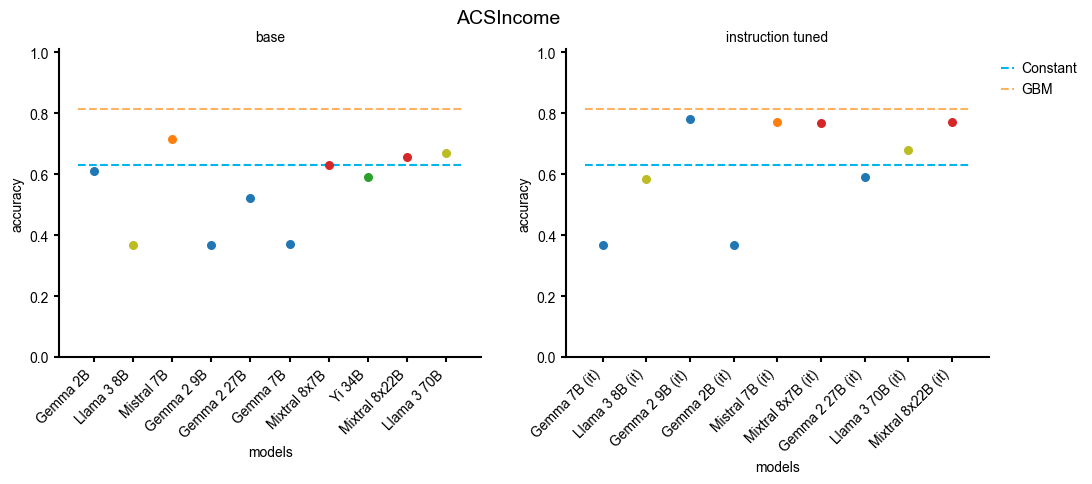

In [113]:
scatter_plot(accuracies_all_models['ACSIncome']['is'],df[(df['task']=='ACSIncome')& (df['shots']==0)], metric_name='accuracy', file_name='same_accuracies.pdf')

#### Agreement Between models

In [69]:
better_models = [m for m in accuracies_all_models['ACSIncome']['is'].keys() if accuracies_all_models['ACSIncome']['is'][m] > baseline_evals['ACSIncome']['Constant']['accuracy']]
better_models_sorted_by_it = [m for m in better_models if not is_instruction_tuned(m)] + [m for m in better_models if is_instruction_tuned(m)]

In [70]:
observed = torch.zeros(len(better_models),len(better_models))
expected = torch.zeros(len(better_models),len(better_models))
for i, mi in enumerate(better_models):
    for j in range(i,len(better_models)):
        mj = better_models[j]
        obs = get_observed_agreement(predictions_all_models['ACSIncome']['is'], mi,mj)
        expect = get_expected_agreement(accuracies_all_models['ACSIncome']['is'], mi,mj)
        observed[i][j] = obs
        observed[j][i] = obs
        expected[i][j] = expect
        expected[j][i] = expect

In [71]:
observed_sorted = torch.zeros(len(better_models),len(better_models))
expected_sorted = torch.zeros(len(better_models),len(better_models))
for i, mi in enumerate(better_models_sorted_by_it):
    for j in range(i,len(better_models_sorted_by_it)):
        mj = better_models[j]
        obs = get_observed_agreement(predictions_all_models['ACSIncome']['is'], mi,mj)
        expect = get_expected_agreement(accuracies_all_models['ACSIncome']['is'], mi,mj)
        observed_sorted[i][j] = obs
        observed_sorted[j][i] = obs
        expected_sorted[i][j] = expect
        expected_sorted[j][i] = expect

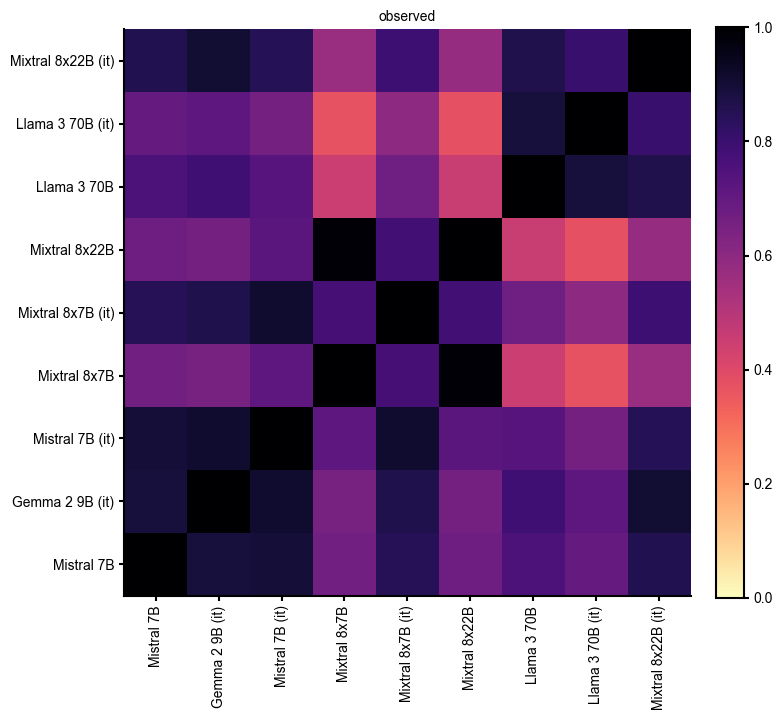

In [241]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title("observed")
im = ax.imshow(observed.numpy(),aspect='equal', extent=(0, len(better_models), 0, len(better_models)), origin='lower', vmin=0, vmax=1, cmap='magma_r')
ax.set_xticks(torch.arange(len(better_models))+0.5, [prettify_model_name(key_to_model(m)) for m in better_models], rotation=90)
ax.set_yticks(torch.arange(len(better_models))+0.5, [prettify_model_name(key_to_model(m)) for m in better_models])

plt.colorbar(im,fraction=0.046, pad=0.04)
plt.savefig(RESULTS_ROOT_DIR_FIG + 'same_observed_agreement.pdf')

plt.show()

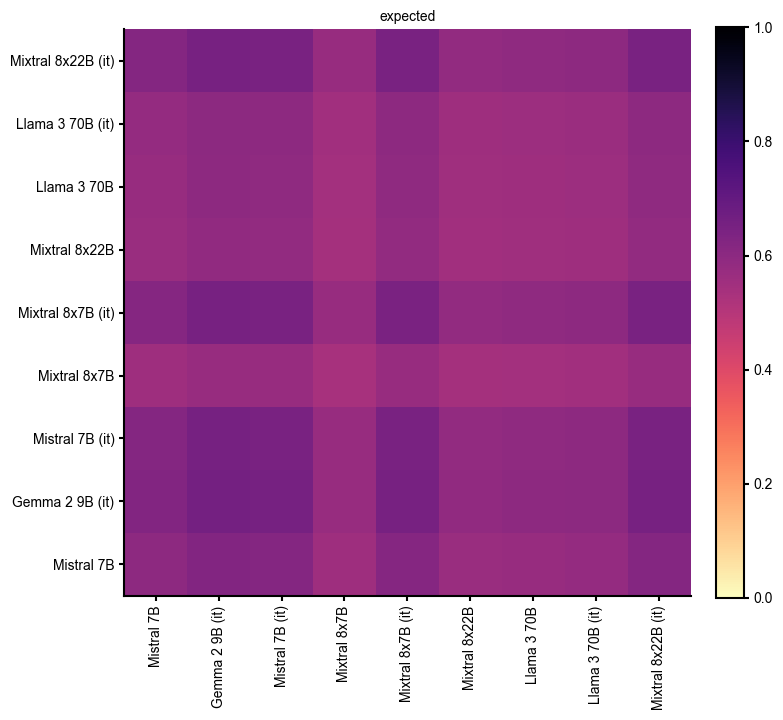

In [242]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

mat_values = expected.numpy()# - expected.numpy()
ax.set_title("expected")

im = ax.imshow(mat_values,aspect='equal', extent=(0, len(better_models), 0, len(better_models)), origin='lower', vmin=0, vmax=1, cmap='magma_r')
ax.set_xticks(torch.arange(len(better_models))+0.5, [prettify_model_name(key_to_model(m)) for m in better_models], rotation=90)
ax.set_yticks(torch.arange(len(better_models))+0.5, [prettify_model_name(key_to_model(m)) for m in better_models])

plt.colorbar(im,fraction=0.046, pad=0.04)
plt.savefig(RESULTS_ROOT_DIR_FIG + 'same_expected_agreement.pdf')
plt.show()


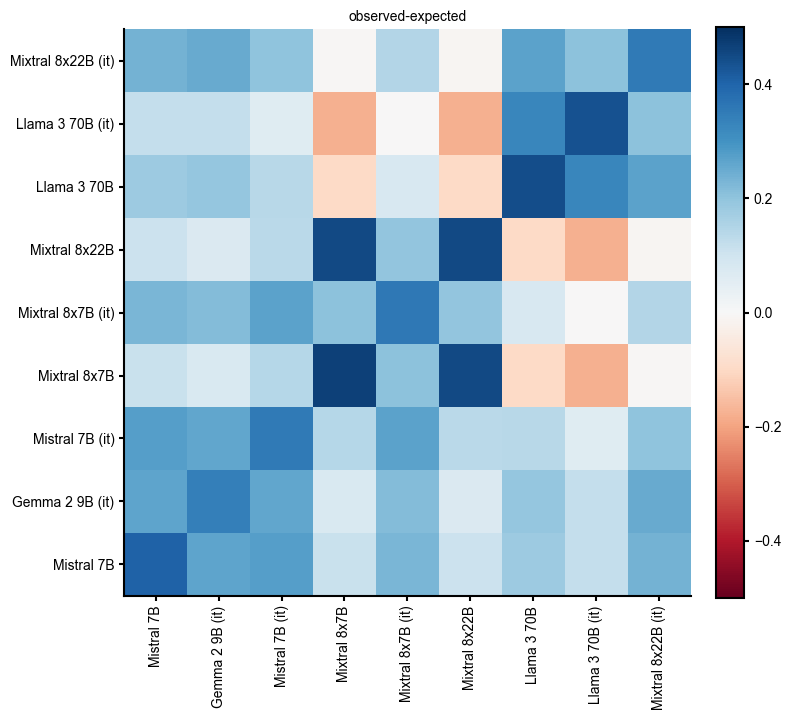

In [245]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

mat_values = observed.numpy() - expected.numpy()
ax.set_title("observed-expected")

# define your scale, with white at zero
vmin = np.floor(10*mat_values.min())/10
vmax = np.ceil(10*mat_values.max())/10
norm = pltcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

im = ax.imshow(mat_values,aspect='equal', extent=(0, len(better_models), 0, len(better_models)), origin='lower', cmap='RdBu', norm=norm)
ax.set_xticks(torch.arange(len(better_models))+0.5, [prettify_model_name(key_to_model(m)) for m in better_models], rotation=90)
ax.set_yticks(torch.arange(len(better_models))+0.5, [prettify_model_name(key_to_model(m)) for m in better_models])

plt.colorbar(im,fraction=0.046, pad=0.04)
plt.savefig(RESULTS_ROOT_DIR_FIG + 'same_relative_agreement.pdf')

plt.show()

#### How many individuals are excluded by all models?

In [123]:
# only look at 'standard' version: bullet list with 'is'
num_models = len(better_models)
num_models
#predictions_all_models['ACSIncome']['is'].sum(axis=1)

9

In [214]:
y_test.sum()/len(y_test)

np.float64(0.3678762391108441)

In [252]:
num_models - predictions_all_models['ACSIncome']['is'].filter(items=better_models).iloc[0]

mistralai--Mistral-7B-v0.1                9
google--gemma-2-9b-it                     9
mistralai--Mistral-7B-Instruct-v0.2       9
mistralai--Mixtral-8x7B-v0.1              9
mistralai--Mixtral-8x7B-Instruct-v0.1     9
mistralai--Mixtral-8x22B-v0.1             9
meta-llama--Meta-Llama-3-70B              9
meta-llama--Meta-Llama-3-70B-Instruct     9
mistralai--Mixtral-8x22B-Instruct-v0.1    9
Name: 238351, dtype: int64

In [229]:
indices = list(set(predictions_all_models['ACSIncome']['is'].filter(items=better_models).index).intersection(set(y_test[y_test==0].index)))



1048583    3
1048588    4
1310739    4
2621460    2
262167     1
          ..
3145715    0
786424     1
1835002    0
524284     0
2359295    0
Length: 105217, dtype: int64

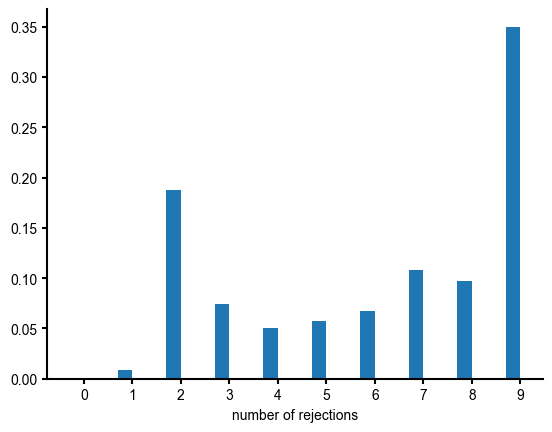

In [280]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("number of rejections")
   
num_models_rejected = num_models - predictions_all_models['ACSIncome']['is'].filter(items=better_models).sum(axis=1)
frac_models = num_models_rejected/num_models
        
counts = np.array([len(num_models_rejected[num_models_rejected==i]) for i in range(0,num_models+1)])#np.histogram(num_models_rejected, bins=np.arange(num_models+1)) #, align='left')
ax.set_xticks(np.arange(num_models+1)+0.45, np.arange(num_models+1))
ax.bar(np.arange(num_models+1)+0.3, counts/sum(counts), width=0.3)
plt.savefig(RESULTS_ROOT_DIR_FIG + 'same_num_agreed.pdf')

plt.show()

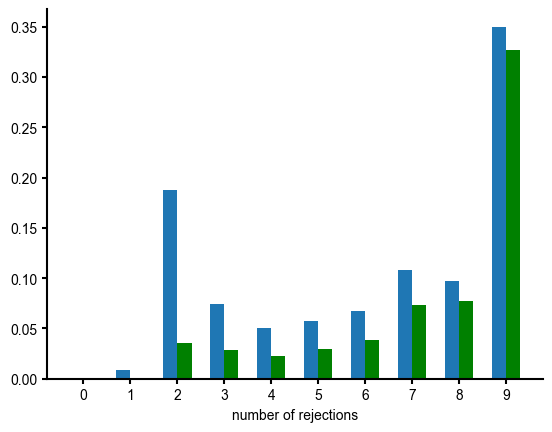

In [281]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("number of rejections")
   
num_models_rejected = num_models - predictions_all_models['ACSIncome']['is'].filter(items=better_models).sum(axis=1)
num_models_correctly_rejected = num_models - predictions_all_models['ACSIncome']['is'].filter(items=better_models).loc[indices].sum(axis=1)
frac_models = num_models_rejected/num_models
        
counts = np.array([len(num_models_rejected[num_models_rejected==i]) for i in range(0,num_models+1)])#np.histogram(num_models_rejected, bins=np.arange(num_models+1)) #, align='left')
counts_corr = np.array([len(num_models_correctly_rejected[num_models_rejected==i]) for i in range(0,num_models+1)])#np.histogram(num_models_rejected, bins=np.arange(num_models+1)) #, align='left')
ax.set_xticks(np.arange(num_models+1)+0.45, np.arange(num_models+1))
ax.bar(np.arange(num_models+1)+0.3, counts/sum(counts), width=0.3)
ax.bar(np.arange(num_models+1)+0.6, counts_corr/sum(counts), width=0.3, color='green')

plt.savefig(RESULTS_ROOT_DIR_FIG + 'same_num_agreed_true.pdf')

plt.show()

In [133]:
dataset = ACSDataset.make_from_task(
            'ACSIncome', cache_dir='data', **acs_dataset_configs
        )

X_train, y_train = dataset.get_train()
X_test, y_test = dataset.get_test()
s_test = None
if dataset.task.sensitive_attribute is not None:
    s_test = dataset.get_sensitive_attribute_data().loc[y_test.index]

Loading ACS data...


In [162]:
num_rejections = predictions_all_models['ACSIncome']['is'].filter(items=better_models).sum(axis=1)
test_cases_with_matching_agreement = y_test.loc[num_rejections[(num_rejections==9)].index]

In [177]:
len(test_cases_with_matching_agreement[test_cases_with_matching_agreement==1])#/len(test_cases_with_matching_agreement)

0

In [149]:
num_agreements[num_agreements==0].index

Index([ 238351, 2995677, 2803585, 2809101, 3134860,  994065,  125195, 1656045,
        768570, 1042304,
       ...
       3228799,  300047,  971083, 2976325, 3168684, 3049345,  675237, 2205318,
       2494279, 2989522],
      dtype='int64', length=58244)

In [148]:
len(num_agreements[num_agreements==0])

58244

IndexError: index 2 is out of bounds for axis 0 with size 2

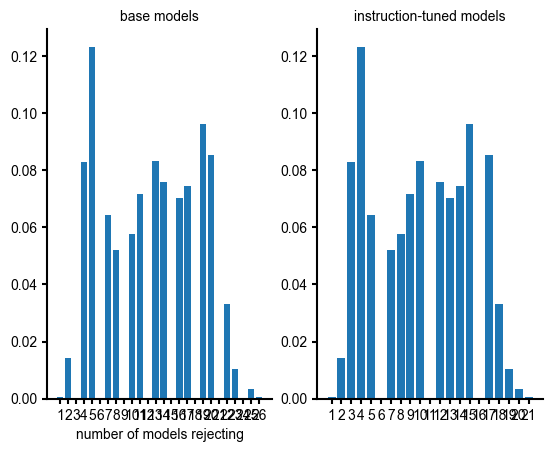

In [116]:
for task_name in ACS_TASKS:
    task_df = df[(df['task']==task_name)& (df['shots']==0)]
    print(task_name)
    risk_scores_prompt, predictions_prompt = get_predictions_per_prompt(task_df)

    it_models = [model for model in predictions_prompt['is'].columns if is_instruction_tuned(key_to_model(model))]
    base_models = [model for model in predictions_prompt['is'].columns if not is_instruction_tuned(key_to_model(model))]

    fig, ax = plt.subplots(1,2)
    ax[0].set_title('base models')
    ax[1].set_title('instruction-tuned models')
    ax[0].set_xlabel("number of models rejecting")
    for i, filtered_models in enumerate([base_models, it_models]):
        num_models = len(filtered_models)

        num_models_rejected = num_models - predictions_prompt['is'].filter(items=filtered_models).sum(axis=1).to_numpy()
        frac_models = num_models_rejected/num_models
        
        counts, bins = np.histogram(num_models_rejected, bins=num_models) #, align='left')
        ax[i].set_xticks(np.arange(num_models)+0.5, range(num_models)+1)
        ax[i].bar(np.arange(num_models)+0.5, counts/sum(counts))
    plt.show()

Consider accuracy?

## Same model, different prompts

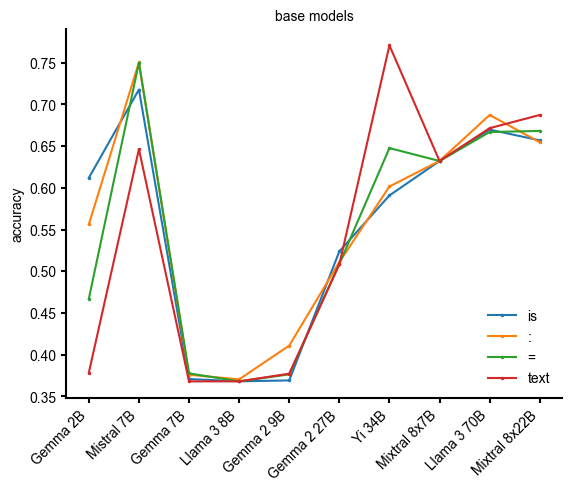

In [307]:
fig, ax = plt.subplots(1,1)
ax.set_title("base models")
for connector in prompt_connectors+['text']:
    accs = accuracies_all_models['ACSIncome'][connector] 
    filtered_models = [m for m in accs.keys() if not is_instruction_tuned(m)]
    filtered_models.sort(key=lambda m: get_model_size_B(m))
    for m in LLM_MODELS:
        if (not is_instruction_tuned(m)) and (model_to_key(m) not in filtered_models):
                print(m)
    ticks_loc = np.arange(len(filtered_models)) + 1
    ax.set_xticks(ticks_loc, [prettify_model_name(key_to_model(m)) for m in filtered_models], rotation=45, ha='right')
    ax.plot(ticks_loc, [accs[model_to_key(model)] for model in filtered_models], label=connector, marker='.')
    ax.set_ylabel('accuracy')
    ax.legend()
plt.savefig(RESULTS_ROOT_DIR_FIG + 'diff_acc_base.pdf')

01-ai/Yi-34B-Chat
01-ai/Yi-34B-Chat
01-ai/Yi-34B-Chat
01-ai/Yi-34B-Chat


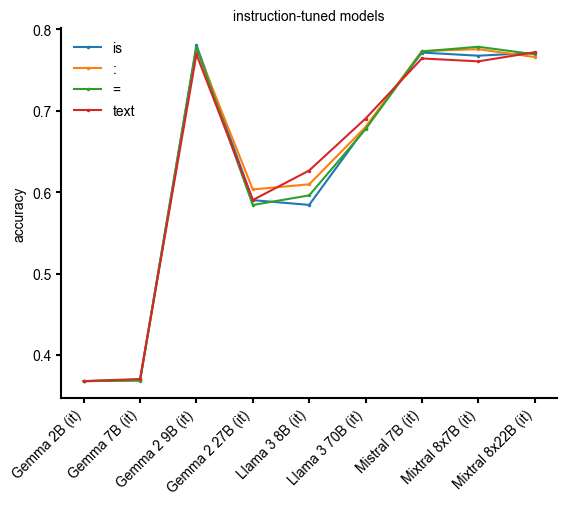

In [305]:
fig, ax = plt.subplots(1,1)
ax.set_title("instruction-tuned models")
for connector in prompt_connectors+['text']:
    accs = accuracies_all_models['ACSIncome'][connector] 
    filtered_models = [m for m in accs.keys() if is_instruction_tuned(m)]
    filtered_models.sort(key=lambda m: LLM_MODELS.index(key_to_model(m)))
    for m in LLM_MODELS:
        if (is_instruction_tuned(m)) and (model_to_key(m) not in filtered_models):
                print(m)
    ticks_loc = np.arange(len(filtered_models)) + 1
    ax.set_xticks(ticks_loc, [prettify_model_name(key_to_model(m)) for m in filtered_models], rotation=45, ha='right')
    ax.plot(ticks_loc, [accs[model_to_key(model)] for model in filtered_models], label=connector, marker='.')
    ax.set_ylabel('accuracy')
    ax.legend()
plt.savefig(RESULTS_ROOT_DIR_FIG + 'diff_acc_it.pdf')

01-ai/Yi-34B-Chat
01-ai/Yi-34B-Chat
01-ai/Yi-34B-Chat
01-ai/Yi-34B-Chat


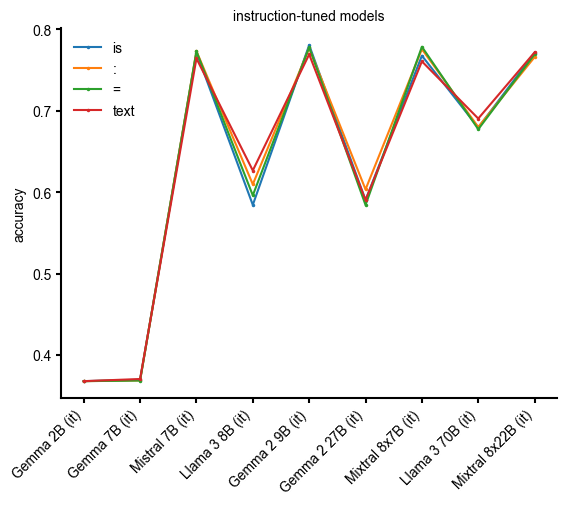

In [306]:
fig, ax = plt.subplots(1,1)
ax.set_title("instruction-tuned models")
for connector in prompt_connectors+['text']:
    accs = accuracies_all_models['ACSIncome'][connector] 
    filtered_models = [m for m in accs.keys() if is_instruction_tuned(m)]
    filtered_models.sort(key=lambda m: get_model_size_B(m))
    for m in LLM_MODELS:
        if (is_instruction_tuned(m)) and (model_to_key(m) not in filtered_models):
                print(m)
    ticks_loc = np.arange(len(filtered_models)) + 1
    ax.set_xticks(ticks_loc, [prettify_model_name(key_to_model(m)) for m in filtered_models], rotation=45, ha='right')
    ax.plot(ticks_loc, [accs[model_to_key(model)] for model in filtered_models], label=connector, marker='.')
    ax.set_ylabel('accuracy')
    ax.legend()
plt.savefig(RESULTS_ROOT_DIR_FIG + 'diff_acc_it.pdf')